
# Chapter 3: 문장 임베딩 실습 (예제, Hugging Face)

여러 문장을 임베딩해 유사도를 비교/시각화하며 임베딩의 직관을 익힙니다.

## 📚 학습 목표
- SentenceTransformer로 문장 임베딩 생성 및 벡터 차원/정규화 이해
- 코사인 유사도 행렬/Top-k 이웃/시각화를 통한 군집 구조 파악
- 임베딩 모델/하이퍼파라미터 변경이 유사도에 미치는 영향 체감

## 📋 실습 구성
- 1️⃣ 환경 설정: Colab 드라이브 마운트/패키지 설치
- 2️⃣ Imports & Model: 모델 로드 및 디바이스 확인
- 3️⃣ 샘플 문장: 도메인 다른 문장 세트 준비
- 4️⃣ 임베딩 생성: 정규화 포함 임베딩 계산
- 5️⃣ 유사도 행렬: 코사인 유사도 표 출력
- 6️⃣ Top-k 이웃/시각화: 최근접 이웃, 히트맵/TSNE 플롯

> ⚠️ 첫 실행 시 모델 다운로드 시간(네트워크/디스크)에 유의하세요.

---
## 1️⃣ Google Colab 환경 설정

이 노트북은 **Google Colab에서 GPU를 사용**하여 실행하도록 설계되었습니다.

### 실행 전 준비
1. **런타임 유형**: `런타임` → `런타임 유형 변경` → `GPU` 선택
2. **아래 셀 실행**: Google Drive 마운트 및 패키지 설치


In [12]:
# ========================================
# Google Colab 환경 설정
# ========================================
from google.colab import drive
import os

# Google Drive 마운트
drive.mount('/content/drive')

# 필요 패키지 설치
!pip -q install -U sentence-transformers torch pandas numpy matplotlib

print("✅ Colab 환경 설정 완료")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


---
## 2️⃣ Imports & Model

In [ ]:
import warnings
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# 경고 억제
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# GPU 자동 감지
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 Using device: {device}")
if device == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# 모델 로드
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
print(f"\nModel: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME, device=device)
print("✅ Model loaded successfully!")


Using model: sentence-transformers/all-MiniLM-L6-v2
Using device: cpu


---
## 3️⃣ Sample Sentences

In [14]:

sentences = [
    # 쌍 1: 요리/음식 관련
    "The chef prepared a delicious pasta dish with fresh ingredients.",
    "A skilled cook made an amazing Italian meal using quality products.",
    
    # 쌍 2: 자연/환경 관련  
    "The forest was filled with tall trees and singing birds.",
    "Woodland areas contained massive oaks and chirping wildlife.",
    
    # 쌍 3: 기술/인공지능 관련
    "Machine learning algorithms can predict customer behavior patterns.",
    "AI models are capable of forecasting user preferences accurately.",
    
    # 쌍 4: 운동/건강 관련
    "Regular exercise helps maintain physical and mental well-being.",
    "Consistent physical activity supports both body and mind health.",
    
    # 쌍 5: 교육/학습 관련
    "Students learn more effectively through interactive teaching methods.",
    "Interactive educational approaches enhance student learning outcomes.",
]
print("Total sentences:", len(sentences))
for i, s in enumerate(sentences):
    print(f"S{i}: {s}")


Total sentences: 10
S0: The chef prepared a delicious pasta dish with fresh ingredients.
S1: A skilled cook made an amazing Italian meal using quality products.
S2: The forest was filled with tall trees and singing birds.
S3: Woodland areas contained massive oaks and chirping wildlife.
S4: Machine learning algorithms can predict customer behavior patterns.
S5: AI models are capable of forecasting user preferences accurately.
S6: Regular exercise helps maintain physical and mental well-being.
S7: Consistent physical activity supports both body and mind health.
S8: Students learn more effectively through interactive teaching methods.
S9: Interactive educational approaches enhance student learning outcomes.


---
## 4️⃣ Embed Sentences

In [ ]:

embeddings = model.encode(
    sentences, 
    convert_to_tensor=True, 
    normalize_embeddings=True
)
print("Embedding shape:", embeddings.shape, "(dim =", embeddings.shape[-1], ")")


Embedding shape: torch.Size([10, 384]) (dim = 384 )


---
## 5️⃣ Cosine Similarity Matrix

In [22]:

sim_matrix = (embeddings @ embeddings.T).cpu().numpy()
import pandas as pd
df_sim = pd.DataFrame(sim_matrix, index=[f"S{i}" for i in range(len(sentences))],
                      columns=[f"S{i}" for i in range(len(sentences))])
pd.set_option("display.precision", 3)
print(df_sim)


       S0     S1     S2     S3     S4     S5     S6     S7     S8     S9
S0  1.000  0.685  0.017 -0.105  0.073  0.090 -0.025  0.018 -0.015  0.006
S1  0.685  1.000 -0.022 -0.081  0.122  0.122  0.030  0.075  0.096  0.056
S2  0.017 -0.022  1.000  0.513  0.019 -0.039  0.011 -0.027  0.038  0.046
S3 -0.105 -0.081  0.513  1.000  0.016 -0.078  0.031  0.094  0.034  0.049
S4  0.073  0.122  0.019  0.016  1.000  0.504  0.013  0.064  0.093  0.021
S5  0.090  0.122 -0.039 -0.078  0.504  1.000  0.044  0.096  0.107  0.084
S6 -0.025  0.030  0.011  0.031  0.013  0.044  1.000  0.712  0.151  0.142
S7  0.018  0.075 -0.027  0.094  0.064  0.096  0.712  1.000  0.134  0.131
S8 -0.015  0.096  0.038  0.034  0.093  0.107  0.151  0.134  1.000  0.827
S9  0.006  0.056  0.046  0.049  0.021  0.084  0.142  0.131  0.827  1.000


---
## 6️⃣ Top-k Nearest Neighbors

In [17]:

import numpy as np

def topk_neighbors(sim, k=3):
    n = sim.shape[0]
    for i in range(n):
        order = np.argsort(-sim[i])
        order = [j for j in order if j != i][:k]
        print(f"\n[S{i}] {sentences[i]}")
        for rank, j in enumerate(order, start=1):
            print(f"  #{rank} (S{j}, {sim[i,j]:.3f}) -> {sentences[j]}")

topk_neighbors(sim_matrix, k=3)



[S0] The chef prepared a delicious pasta dish with fresh ingredients.
  #1 (S1, 0.685) -> A skilled cook made an amazing Italian meal using quality products.
  #2 (S5, 0.090) -> AI models are capable of forecasting user preferences accurately.
  #3 (S4, 0.073) -> Machine learning algorithms can predict customer behavior patterns.

[S1] A skilled cook made an amazing Italian meal using quality products.
  #1 (S0, 0.685) -> The chef prepared a delicious pasta dish with fresh ingredients.
  #2 (S5, 0.122) -> AI models are capable of forecasting user preferences accurately.
  #3 (S4, 0.122) -> Machine learning algorithms can predict customer behavior patterns.

[S2] The forest was filled with tall trees and singing birds.
  #1 (S3, 0.513) -> Woodland areas contained massive oaks and chirping wildlife.
  #2 (S9, 0.046) -> Interactive educational approaches enhance student learning outcomes.
  #3 (S8, 0.038) -> Students learn more effectively through interactive teaching methods.

[S3] Wood

## 6) Heatmap Visualization

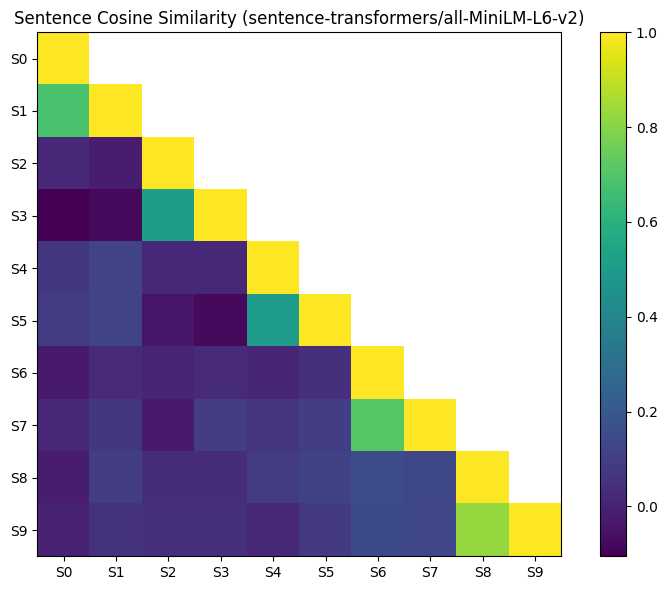

In [24]:

import matplotlib.pyplot as plt

# 대각선 위쪽을 마스킹하여 하삼각 행렬만 표시
masked_matrix = sim_matrix.copy()
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        masked_matrix[i, j] = np.nan

plt.figure(figsize=(8,6))
plt.imshow(masked_matrix, interpolation="nearest")
plt.colorbar()
plt.title(f"Sentence Cosine Similarity ({MODEL_NAME})")
plt.xticks(range(len(sentences)), [f"S{i}" for i in range(len(sentences))])
plt.yticks(range(len(sentences)), [f"S{i}" for i in range(len(sentences))])
plt.tight_layout()
plt.show()


## 7) t-SNE 2D Scatter Plot


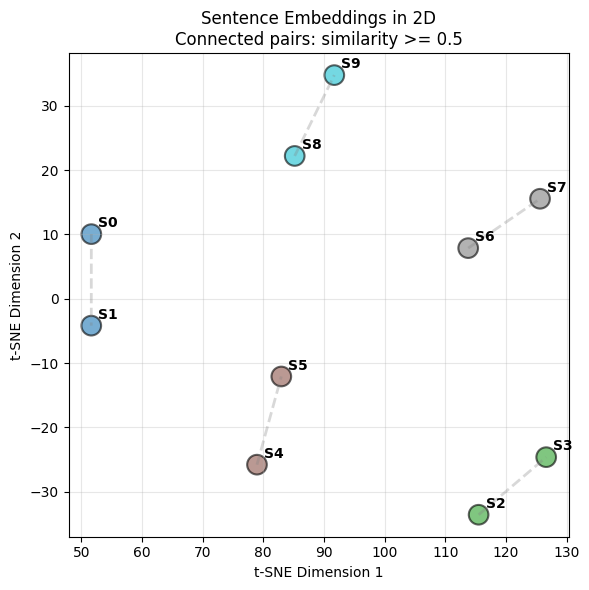


Note: t-SNE with perplexity=5 optimized for small dataset
t-SNE is non-linear and good at preserving local neighborhood structure


In [26]:
from sklearn.manifold import TSNE
import networkx as nx

# Define colors for each pair (5 pairs, 5 colors)
colors = plt.cm.tab10(np.linspace(0, 1, 5))
sentence_colors = [colors[i//2] for i in range(10)]

THRESHOLD = 0.5

# Create graph
G = nx.Graph()

# Add nodes (all sentences)
for i in range(len(sentences)):
    G.add_node(f"S{i}")

edges_added = []
for i in range(len(sentences)):
    for j in range(i+1, len(sentences)):
        if sim_matrix[i, j] >= THRESHOLD:
            G.add_edge(f"S{i}", f"S{j}", weight=sim_matrix[i, j])
            edges_added.append((i, j, sim_matrix[i, j]))
            
# Perform t-SNE (use perplexity appropriate for small dataset)
perplexity = min(5, len(sentences) - 1)  # Max perplexity is n_samples - 1
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, 
            init='pca', learning_rate='auto')
embeddings_tsne = tsne.fit_transform(embeddings.cpu().numpy())

# Create scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], 
           c=sentence_colors, s=200, alpha=0.6, edgecolors='black', linewidth=1.5)

# Add labels
for i, (x, y) in enumerate(embeddings_tsne):
    plt.annotate(f'S{i}', (x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold')

# Draw connections for similar pairs (threshold >= 0.5)
for i, j, sim in edges_added:
    x1, y1 = embeddings_tsne[i]
    x2, y2 = embeddings_tsne[j]
    plt.plot([x1, x2], [y1, y2], 'gray', alpha=0.3, linestyle='--', linewidth=2)

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title(f'Sentence Embeddings in 2D\nConnected pairs: similarity >= 0.5')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNote: t-SNE with perplexity={perplexity} optimized for small dataset")
print("t-SNE is non-linear and good at preserving local neighborhood structure")
